In [1]:
import warnings
import math
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
import os
import urllib
import zipfile
from pathlib import Path

cuda:0


In [13]:
# loading mltpl snr noisy data
data_folder = Path(r"C:\Users\Guillaume\Documents\data")
data_all = []


filters = ['tif','tiff']

files = os.listdir(data_folder)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} because not in filters")
        files.remove(f)

for f in files:
    im = imread(data_folder / f)
    data_all.append(im)
    print(f"{f}:\t shape: {im.shape}")

print(f"\nFound {len(files)} files.")

data_all = np.stack(data_all)

print(f"\nAll data loaded in numpy array `data_all`, of shape: {data_all.shape}, corresponding to: (#files,#frames,H,W)")

removing n2v because not in filters
rec_c01_rec_CAM.tiff:	 shape: (6, 1416, 1392)
rec_c02_rec_CAM.tiff:	 shape: (6, 1416, 1392)
rec_c03_rec_CAM.tiff:	 shape: (6, 1416, 1392)

Found 3 files.

All data loaded in numpy array `data_all`, of shape: (3, 6, 1416, 1392), corresponding to: (#files,#frames,H,W)


In [22]:
# loading n2v data
data_folder = Path(r"C:\Users\Guillaume\Documents\data\n2v")
data_n2v = []

filters = ['tif','tiff']

files_n2v = os.listdir(data_folder)

for f in files_n2v:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} because not in filters")
        files_n2v.remove(f)

for f in files_n2v:
    im = imread(data_folder / f)
    data_n2v.append(im[1])
    print(f"{f}:\t shape: {im[1].shape}")

print(f"\nFound {len(files)} files.")

data_n2v = np.stack(data_n2v)

print(f"\nAll data loaded in numpy array `data_n2v`, of shape: {data_n2v.shape}, corresponding to: (#files,#frames,H,W)")

img_and_denoised_00.tiff:	 shape: (1416, 1392)
img_and_denoised_01.tiff:	 shape: (1416, 1392)
img_and_denoised_02.tiff:	 shape: (1416, 1392)

Found 3 files.

All data loaded in numpy array `data_n2v`, of shape: (3, 1416, 1392), corresponding to: (#files,#frames,H,W)


In [23]:
# In this dataset everything is low, high followed by bleaching, so:
frame_low = 0
frame_high = 1

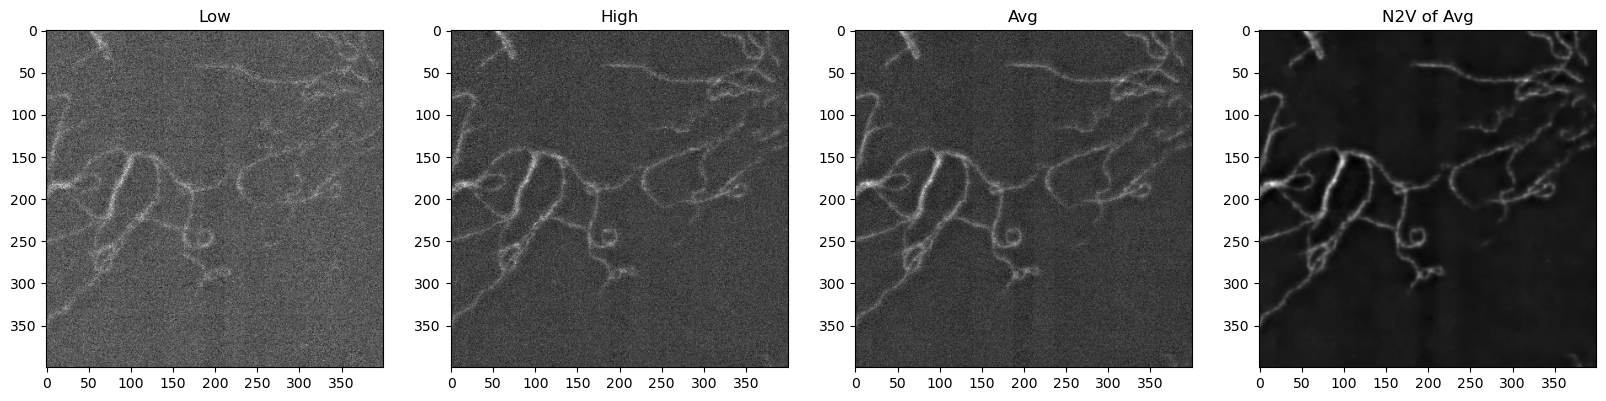

In [24]:
# Define highs,lows, avgs and n2v and normalize, display to check
highs = data_all[:,1]
lows = data_all[:,0]
avgs = np.mean(data_all[:,frame_high:-2],axis = 1)
n2v = data_n2v.copy()

highs_norm = (highs - np.mean(highs))/np.std(highs)
lows_norm = (lows - np.mean(lows))/np.std(lows)
avgs_norm = (avgs - np.mean(avgs))/np.std(avgs)
n2v_norm = (n2v - np.mean(n2v))/np.std(n2v)

crop_size = 400
file_idx = 0
h,w = data_all[file_idx,0].shape

# crop image
starty,startx = h//2-crop_size//2, w//2-crop_size//2
stopy,stopx = h//2+crop_size//2,w//2+crop_size//2

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(lows_norm[file_idx,starty:stopy,starty:stopy],cmap='gray')
plt.title("Low")
plt.subplot(1,4,2)
plt.imshow(highs_norm[file_idx,starty:stopy,starty:stopy],cmap='gray')
plt.title("High")
plt.subplot(1,4,3)
plt.imshow(avgs_norm[file_idx,starty:stopy,starty:stopy],cmap='gray')
plt.title("Avg")
plt.subplot(1,4,4)
plt.imshow(n2v_norm[file_idx,starty:stopy,starty:stopy],cmap='gray')
plt.title("N2V of Avg")

plt.show()

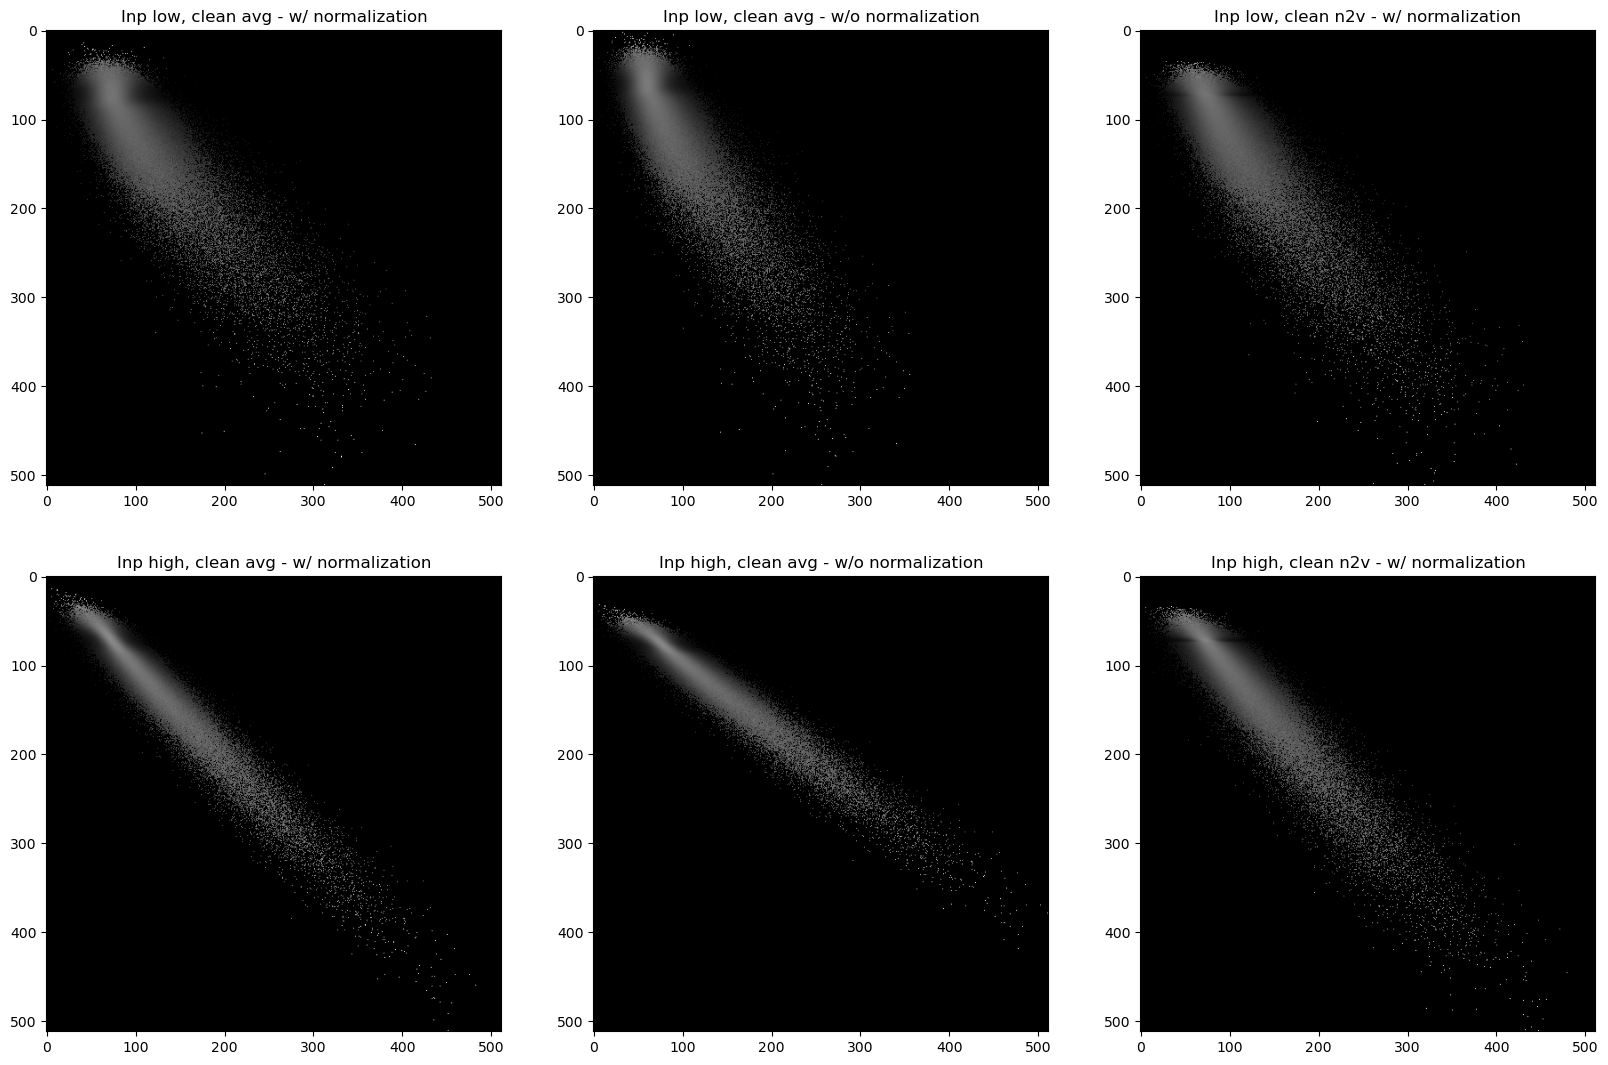

In [28]:
# Display low and high hist-badsed noise models, w/ and w/o normalization

bins = 512

# low
plt.figure(figsize=(20,13))
plt.subplot(2,3,1)
minVal, maxVal = min(np.min(lows_norm),np.min(avgs_norm)), max(np.max(lows_norm),np.max(avgs_norm))
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, lows_norm,avgs_norm)
plt.title("Inp low, clean avg - w/ normalization")
plt.imshow(histogram[0]**0.25, cmap='gray')

plt.subplot(2,3,2)
minVal, maxVal = min(np.min(lows),np.min(avgs)), max(np.max(lows),np.max(avgs))
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, lows,avgs)
plt.title("Inp low, clean avg - w/o normalization")
plt.imshow(histogram[0]**0.25, cmap='gray')

plt.subplot(2,3,3)
minVal, maxVal = min(np.min(lows_norm),np.min(n2v_norm)), max(np.max(lows_norm),np.max(n2v_norm))
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, lows_norm,n2v_norm)
plt.title("Inp low, clean n2v - w/ normalization")
plt.imshow(histogram[0]**0.25, cmap='gray')

#high
plt.subplot(2,3,4)
minVal, maxVal = min(np.min(highs_norm),np.min(avgs_norm)), max(np.max(highs_norm),np.max(avgs_norm))
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, highs_norm,avgs_norm)
plt.title("Inp high, clean avg - w/ normalization")
plt.imshow(histogram[0]**0.25, cmap='gray')

plt.subplot(2,3,5)
minVal, maxVal = min(np.min(highs),np.min(avgs)), max(np.max(highs),np.max(avgs))
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, highs,avgs)
plt.title("Inp high, clean avg - w/o normalization")
plt.imshow(histogram[0]**0.25, cmap='gray')

plt.subplot(2,3,6)
minVal, maxVal = min(np.min(highs_norm),np.min(n2v_norm)), max(np.max(highs_norm),np.max(n2v_norm))
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, highs_norm,n2v_norm)
plt.title("Inp high, clean n2v - w/ normalization")
plt.imshow(histogram[0]**0.25, cmap='gray')

plt.show()

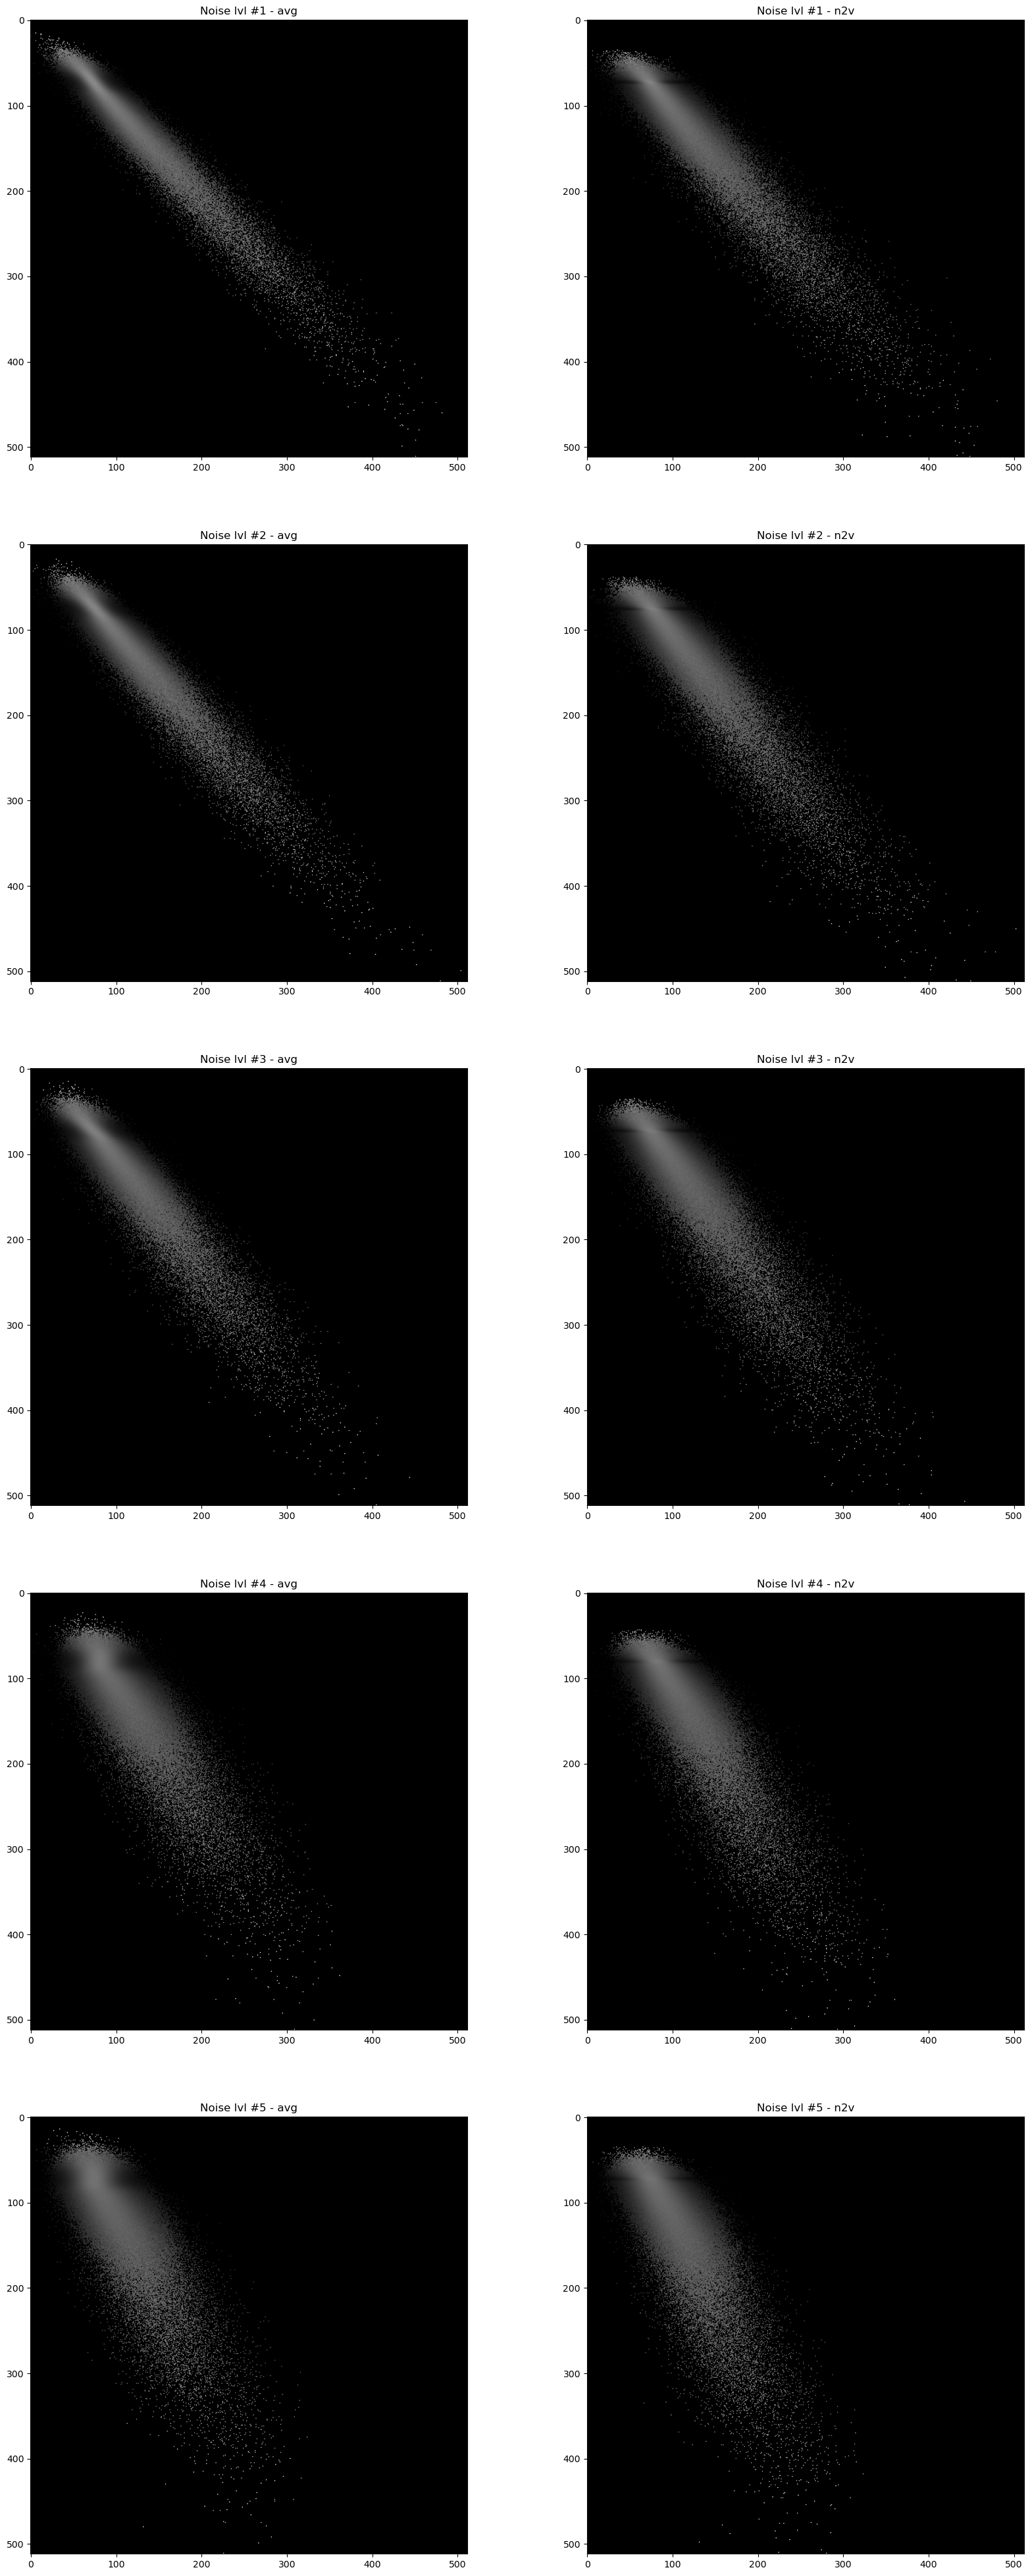

In [41]:
# Display hist based models for each "bleaching noise level" for both  clean = avg and clean = n2v
bins = 512
plt.figure(figsize=(20,50))
for i in range(1,6):
    ims = data_all[:,i]
    ims_norm = (ims - np.mean(ims))/np.std(ims)
    minVal = min(np.min(ims_norm),np.min(avgs_norm))
    maxVal = max(np.max(ims_norm),np.max(avgs_norm))
    histogram1 = histNoiseModel.createHistogram(bins,minVal,maxVal,ims_norm,avgs_norm)
    
    minVal = min(np.min(ims_norm),np.min(n2v_norm))
    maxVal = max(np.max(ims_norm),np.max(n2v_norm))
    histogram2 = histNoiseModel.createHistogram(bins,minVal,maxVal,ims_norm,n2v_norm)


    plt.subplot(5,2,2*i-1)
    plt.title(f"Noise lvl #{i} - avg")
    plt.imshow(histogram1[0]**0.25,cmap='gray')

    plt.subplot(5,2,2*i)
    plt.title(f"Noise lvl #{i} - n2v")
    plt.imshow(histogram2[0]**0.25,cmap='gray')

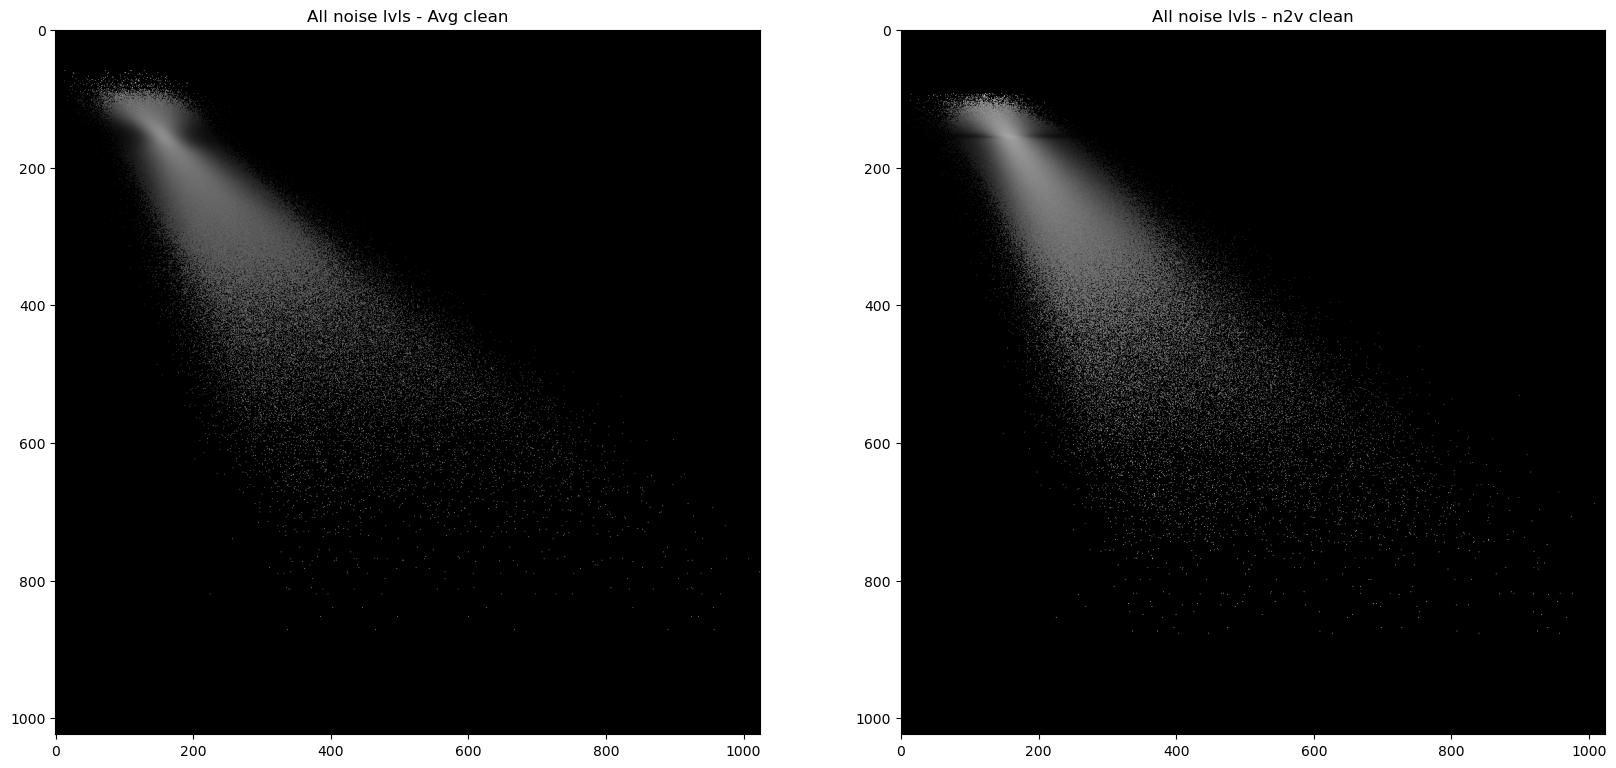

In [32]:
# Noise models with all snr lvls

all_noise = np.reshape(data_all[:,1::],(3*5,data_all.shape[2],data_all.shape[3]))
all_noise_norm = (all_noise - np.mean(all_noise)) / np.std(all_noise)
avgs_norm_forallnoise = np.repeat(avgs_norm,5,axis=0)
n2v_norm_forallnoise = np.repeat(n2v_norm,5,axis=0)

bins = 1024
minVal = min(np.min(all_noise_norm),np.min(avgs_norm_forallnoise))
maxVal = max(np.max(all_noise_norm),np.max(avgs_norm_forallnoise))
histogram1 = histNoiseModel.createHistogram(bins,minVal,maxVal,all_noise_norm,avgs_norm_forallnoise)


minVal = min(np.min(all_noise_norm),np.min(n2v_norm_forallnoise))
maxVal = max(np.max(all_noise_norm),np.max(n2v_norm_forallnoise))
histogram2 = histNoiseModel.createHistogram(bins,minVal,maxVal,all_noise_norm,n2v_norm_forallnoise)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(histogram1[0]**0.25,cmap='gray')
plt.title("All noise lvls - Avg clean")
plt.subplot(1,2,2)
plt.imshow(histogram2[0]**0.25,cmap='gray')
plt.title("All noise lvls - n2v clean")
plt.show()